<a href="https://colab.research.google.com/github/mtamar/linear_glens/blob/main/gigalens_linefit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gigalens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 10.7 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [4]:
!pip install corner
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.9 MB/s eta 0:00:00


In [2]:
! pip install tensorflow_probability==0.17.0

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner
from tensorflow_probability import (
    distributions as tfd,
    bijectors as tfb,
    experimental as tfe,
)
from sklearn.neighbors import KernelDensity
from scipy import signal

"""from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import epl, shear"""

sns.set_style("whitegrid")
tfd = tfp.distributions

## Line Fit

In [10]:
# define priors
line_prior = tfd.JointDistributionNamed(
                  dict(
                      slope=tfd.Uniform(-10,10),
                      y_intercept=tfd.Uniform(-10,10),
                  )
              )

In [11]:
# test bijectors

example = line_prior.sample(20)
ms = example['slope']
bs = example['y_intercept']

param_priors = tf.reshape(tf.stack([ms,bs], axis = 0), (10,-1))

example = line_prior.sample(seed=0)
size = int(tf.size(tf.nest.flatten(example)))
pack_bij = tfb.Chain(
    [
        tfb.pack_sequence_as(example),
        #tfb.Split(size),
        #tfb.Reshape(event_shape_out=(-1,), event_shape_in=(size, -1)),
        #tfb.Transpose(perm=(1, 0)),
    ]
)
unconstraining_bij = line_prior.experimental_default_event_space_bijector()
bij = tfb.Chain([unconstraining_bij, pack_bij])

print(ms)

bruh = bij.forward([ms,bs])
m_bij = bruh['slope']
print(m_bij)


tf.Tensor(
[-2.879157    9.858704    6.405594    8.582035    3.0049086   2.3835135
  4.8374796  -7.164519    9.377148    9.919203   -7.2847867  -4.1307473
  9.101679    4.5823746  -4.202347    3.0503826   0.99595547 -7.851467
  2.2038555  -4.2268276 ], shape=(20,), dtype=float32)
tf.Tensor(
[-8.936129   9.998954   9.967009   9.996252   9.055908   8.311229
  9.842707  -9.984541   9.998307   9.999016  -9.986292  -9.683666
  9.99777    9.797461  -9.705202   9.095981   4.6052527 -9.992219
  8.011904  -9.712229 ], shape=(20,), dtype=float32)


In [12]:
import random

# define truth parameters and noisy data

m = 2.0
b = -3.0
err = 1.2

truth = [{'slope': m, 'y_intercept': b}]

num_points = 100

x_observed = []
for i in range(num_points):
  x = random.uniform(0,10)
  x_observed.append(x)

x_observed = tf.cast(tf.constant(x_observed),tf.float32)
m = tf.cast(tf.constant([m]),tf.float32)
b = tf.cast(tf.constant([b]),tf.float32)

@tf.function
def line_model(x,params):
  m,b = params
  mx = tf.tensordot(m,x,axes=0)
  b_ = b[:,None]
  y = mx + b_
  return y

def line_noisy(x,params):
  m,b = params
  return line_model(x,(m,b)) + np.random.normal(loc=0.0,scale = np.sqrt(err), size = len(x))

y_observed = line_noisy(x_observed, (m,b))
y_observed = np.array(y_observed).flatten()
y_observed = tf.cast(tf.constant(y_observed),tf.float32)

# plot data points and truth line

plt.plot(x_observed, y_observed, '.', ms = 10)

plt.errorbar(x_observed, y_observed, yerr = err, marker = 's', fmt = 'None', ecolor = 'red', alpha = 0.3)
plt.plot(x_observed, tf.reshape(line_model(x_observed, (m,b)),(num_points)), color = 'orange')
plt.show()



2024-01-26 16:02:26.336342: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2024-01-26 16:02:26.336370: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2024-01-26 16:02:26.336394: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:438 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: Graph execution error:

Detected at node 'Tensordot/MatMul' defined at (most recent call last):
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_221051/1640950540.py", line 34, in <module>
      y_observed = line_noisy(x_observed, (m,b))
    File "/tmp/ipykernel_221051/1640950540.py", line 32, in line_noisy
      return line_model(x,(m,b)) + np.random.normal(loc=0.0,scale = np.sqrt(err), size = len(x))
    File "/tmp/ipykernel_221051/1640950540.py", line 25, in line_model
      mx = tf.tensordot(m,x,axes=0)
Node: 'Tensordot/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node Tensordot/MatMul}}]] [Op:__inference_line_model_751]

In [7]:
from tqdm.auto import trange, tqdm

class ModellingSequence():
    def __init__(self, x_observed, y_observed):
        self.x_observed = x_observed
        self.y_observed = y_observed

        # line bijector
        example = line_prior.sample(seed=0)
        self.pack_bij = tfb.Chain(
            [
                tfb.pack_sequence_as(example),
                #tfb.Split(size),
                #tfb.Reshape(event_shape_out=(-1,), event_shape_in=(size, -1)),
                #tfb.Transpose(perm=(1, 0)),
            ]
        )
        self.unconstraining_bij = line_prior.experimental_default_event_space_bijector()
        self.bij = tfb.Chain([self.unconstraining_bij, self.pack_bij])

    #@tf.function
    def log_prob(self, x_observed, y_observed, m, b):

        # map parameters to constrained space
        constrained_params = self.bij.forward([m,b])
        m_bij = constrained_params['slope']
        b_bij = constrained_params['y_intercept']

        # reshaping to match reinterpreted_ batch_ndims
        y_model = tf.reshape(line_model(x_observed, (m_bij,b_bij)), (num_points,-1))
        y_model = tf.reshape(y_model,(len(m_bij),num_points))
        errs = tf.constant(err, shape=(len(m_bij),num_points))

        log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)
        log_prior = line_prior.log_prob(dict(slope=m_bij,y_intercept=b_bij)) + self.unconstraining_bij.forward_log_det_jacobian(self.pack_bij.forward([m,b]))

        return log_like + log_prior, tf.reduce_mean((y_observed - line_model(x_observed,(m_bij,b_bij)))**2/errs, axis = 1)


    def MAP(self, optimizer, start=None, n_samples=500, num_steps=350, seed=0):
        tf.random.set_seed(seed)
        start = line_prior.sample(n_samples)
        ms = start['slope']
        bs = start['y_intercept']

        trial = tf.Variable(self.bij.inverse(start))

        ms_train = tf.Variable(trial[0])
        bs_train = tf.Variable(trial[1])


        @tf.function
        def train_step():
            with tf.GradientTape() as tape:
                log_probability, square_err = self.log_prob(self.x_observed, self.y_observed, ms_train, bs_train)
                agg_loss = tf.reduce_mean(-log_probability / len(x_observed))
            gradients = tape.gradient(agg_loss, [ms_train,bs_train])
            optimizer.apply_gradients(zip(gradients, [ms_train,bs_train]))

            return log_probability, square_err

        # get chi^2 and log probabilities for each step
        square_errs = []
        log_probs = []

        with trange(num_steps) as pbar:
            for _ in pbar:
                lp, square_err = train_step()
                square_errs.append(square_err)
                log_probs.append(lp)
                pbar.set_description(f"Chi Squared: {(np.nanmin(square_err)):.8f}")

        return ms_train, bs_train, log_probs, square_errs

    @tf.function
    def log_prob_SVI(self, x_observed, y_observed, params):
        m = params[:,0]
        b = params[:,1]

        # map parameters to constrained space
        constrained_params = self.bij.forward([m,b])
        m_bij = constrained_params['slope']
        b_bij = constrained_params['y_intercept']

        y_model = tf.reshape(line_model(x_observed, (m_bij,b_bij)), (num_points,-1))
        y_model = tf.reshape(y_model,(len(m_bij),num_points))
        errs = tf.constant(err, shape=(len(m_bij),num_points))

        log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)
        log_prior = line_prior.log_prob(dict(slope=m_bij,y_intercept=b_bij)) + self.unconstraining_bij.forward_log_det_jacobian(self.pack_bij.forward([m,b]))

        return tf.squeeze(log_like + log_prior)

    def SVI(self, optimizer, start, n_vi=250, init_scales=1e-3, num_steps=500, seed=2):
        tf.random.set_seed(seed)

        start = tf.squeeze(start)
        scale = (
          np.ones(len(start)).astype(np.float32) * init_scales
          if np.size(init_scales) == 1
          else init_scales
        )
        q_z = tfd.MultivariateNormalTriL(
          loc=tf.Variable(start),
          scale_tril=tfp.util.TransformedVariable(
              np.diag(scale),
              tfp.bijectors.FillScaleTriL(diag_bijector=tfb.Exp(), diag_shift=1e-6),
              name="stddev",
          ),
        )

        losses = tfp.vi.fit_surrogate_posterior(
          lambda z: self.log_prob_SVI(self.x_observed, self.y_observed, z),
          surrogate_posterior=q_z,
          sample_size=n_vi,
          optimizer=optimizer,
          num_steps=num_steps,

        )

        return q_z, losses

    def HMC(
          self,
          q_z,
          init_eps=0.3,
          init_l=3,
          n_hmc=50,
          num_burnin_steps=250,
          num_results=750,
          max_leapfrog_steps=30,
          seed=3,
          ):

      def tqdm_progress_bar_fn(num_steps):
          return iter(tqdm(range(num_steps), desc="", leave=True))

      tf.random.set_seed(seed)

      mc_start = q_z.sample(n_hmc)
      cov_estimate = q_z.covariance()

      momentum_distribution = (
          tfe.distributions.MultivariateNormalPrecisionFactorLinearOperator(
              precision_factor=tf.linalg.LinearOperatorLowerTriangular(
                  tf.linalg.cholesky(cov_estimate),
              ),
              precision=tf.linalg.LinearOperatorFullMatrix(cov_estimate),
          )
      )

      @tf.function
      def run_chain():
          num_adaptation_steps = int(num_burnin_steps * 0.8)
          start = tf.identity(mc_start)

          mc_kernel = tfe.mcmc.PreconditionedHamiltonianMonteCarlo(
              target_log_prob_fn=lambda z: self.log_prob_SVI(self.x_observed, self.y_observed, z),
              momentum_distribution=momentum_distribution,
              step_size=init_eps,
              num_leapfrog_steps=init_l,
          )

          mc_kernel = tfe.mcmc.GradientBasedTrajectoryLengthAdaptation(
              mc_kernel,
              num_adaptation_steps=num_adaptation_steps,
              max_leapfrog_steps=max_leapfrog_steps,
          )
          mc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
              inner_kernel=mc_kernel, num_adaptation_steps=num_adaptation_steps
          )

          pbar = tfe.mcmc.ProgressBarReducer(
              num_results + num_burnin_steps - 1, progress_bar_fn=tqdm_progress_bar_fn
          )
          mc_kernel = tfe.mcmc.WithReductions(mc_kernel, pbar)

          return tfp.mcmc.sample_chain(
              num_results=num_results,
              num_burnin_steps=num_burnin_steps,
              current_state=start,
              kernel=mc_kernel,
              seed=seed,
          )

      return run_chain()




In [8]:
fitter = ModellingSequence(x_observed, y_observed)

In [9]:
# fitting MAP

schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-1, 500, 1e-3)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=500, num_steps=500, seed=0)

  0%|          | 0/500 [00:00<?, ?it/s]

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


In [10]:
# get best MAP results
ms_train, bs_train, log_probs, square_errs = MAP
lps = fitter.log_prob(x_observed, y_observed, ms_train, bs_train)[0]
best_idx = tf.argmax(lps).numpy()
MAP_m = ms_train[best_idx].numpy()
MAP_b = bs_train[best_idx].numpy()

best = tf.constant([MAP_m, MAP_b])

# map to physical parameters

MAP_bij = fitter.bij.forward([MAP_m, MAP_b])
MAP_m_bij = MAP_bij['slope'].numpy()
MAP_b_bij = MAP_bij['y_intercept'].numpy()
best_bij = tf.constant([MAP_m_bij, MAP_b_bij])

print(best)
print(best_bij)

tf.Tensor([ 0.41556624 -0.6534199 ], shape=(2,), dtype=float32)
tf.Tensor([ 2.0484362 -3.155614 ], shape=(2,), dtype=float32)


Text(0.5, 1.0, 'best -log prob vs steps')

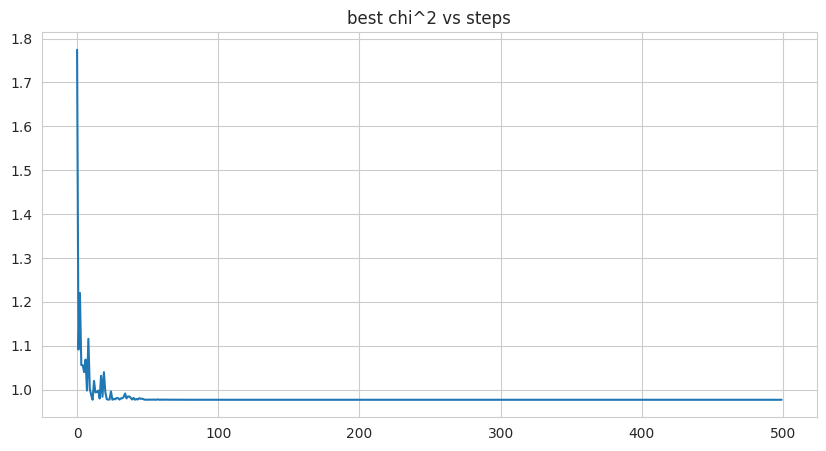

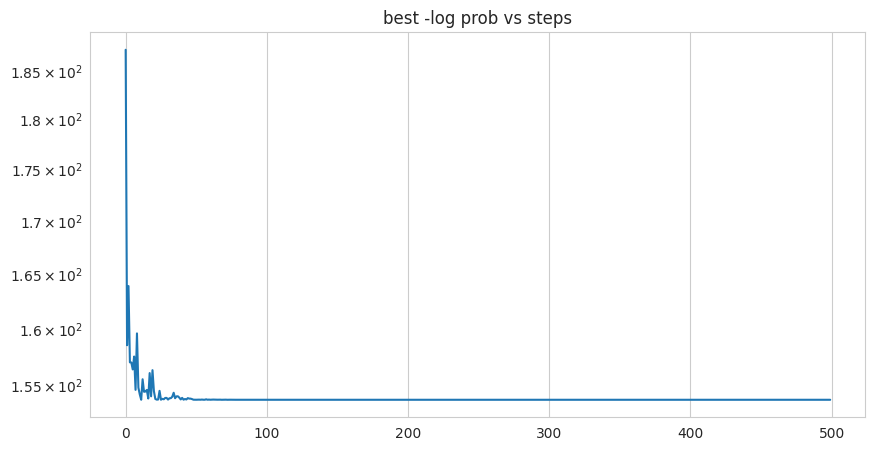

In [39]:
# plot best walker at each iteration

chi2s = np.array(square_errs)
best_chi2s = []
for i in range(len(chi2s[:,0])):
  best_chi2_idx = np.argmin(chi2s[i,:])
  best_chi2 = chi2s[i,best_chi2_idx]
  best_chi2s.append(best_chi2)

best_chi2s = np.array(best_chi2s)


plt.figure(figsize=(10, 5))
plt.plot(best_chi2s)
plt.title('best chi^2 vs steps')


log_probs = np.array(log_probs)
best_log_probs = []
for i in range(len(log_probs[:,0])):
  best_log_prob_idx = np.argmax(log_probs[i,:])
  best_log_prob = log_probs[i,best_log_prob_idx]
  best_log_probs.append(best_log_prob)

best_log_probs = np.array(best_log_probs)

plt.figure(figsize=(10, 5))
plt.plot(-best_log_probs)
plt.yscale('log')
plt.title('best -log prob vs steps')



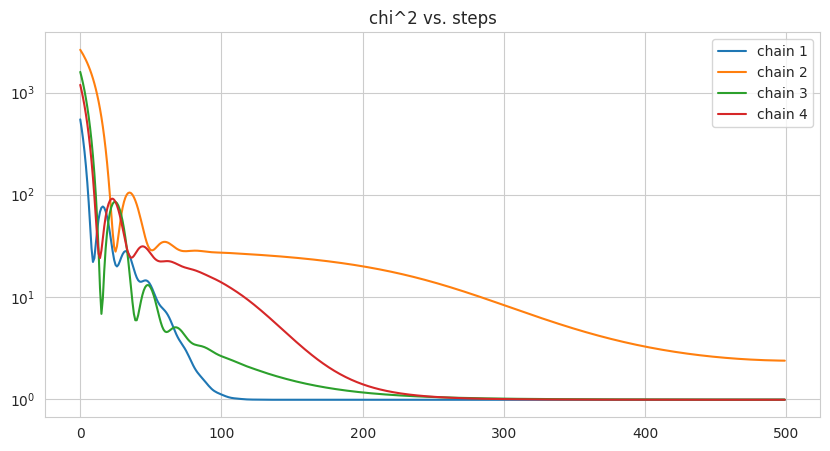

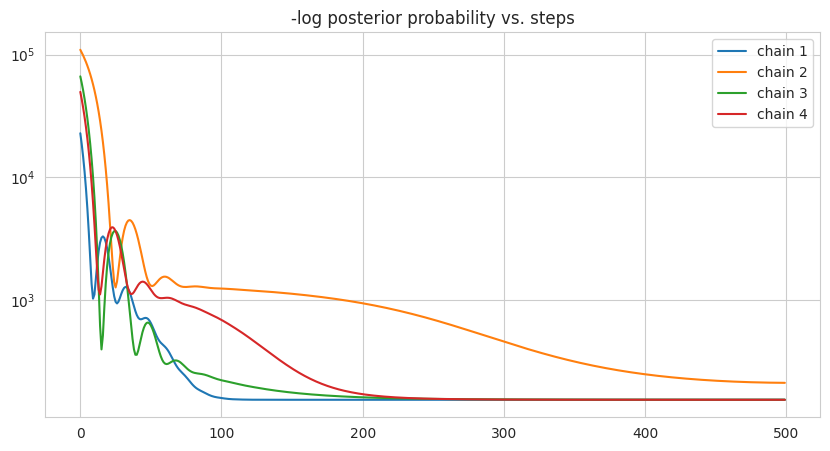

In [40]:
# chi^2 plot
chi2s = np.array(square_errs)
chain = chi2s[:,0:4]

plt.figure(figsize=(10, 5))
plt.plot(chain, label=['chain 1','chain 2','chain 3','chain 4']);
plt.yscale('log')
plt.title('chi^2 vs. steps')
plt.legend()

# posterior probability plot
log_probs = np.array(log_probs)
chain = log_probs[:,0:4]

plt.figure(figsize=(10, 5))
plt.plot(-chain, label=['chain 1','chain 2','chain 3','chain 4']);
plt.yscale('log')
plt.title('-log posterior probability vs. steps')
plt.legend()


In [41]:
# fit SVI
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=300, num_steps=1400)

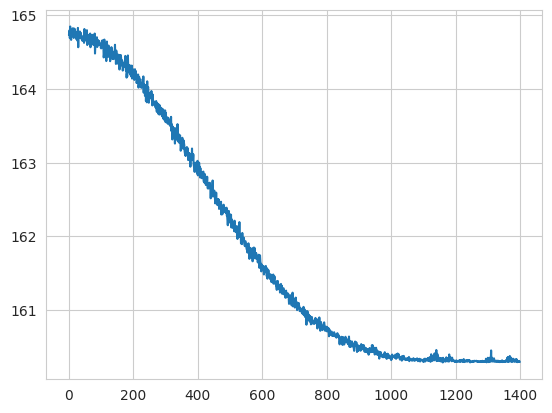

In [42]:
plt.plot(losses)

tf.Tensor([ 2. -3.], shape=(2,), dtype=float32)


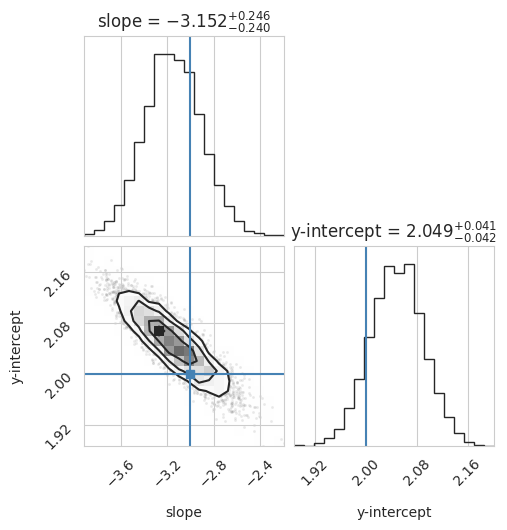

In [43]:
# make corner plot for SVI step
get_samples = lambda x:tf.convert_to_tensor([
    x[0]['slope'],
    x[0]['y_intercept']
])

unconstrained_samples = q_z.sample(5000)

# map to physical space
unconstrained_ms = unconstrained_samples[:,0]
unconstrained_bs = unconstrained_samples[:,1]

physical_samples = fitter.bij.forward([unconstrained_ms, unconstrained_bs])

markers = get_samples(truth)

print(markers)
corner(physical_samples, truths = truth[0], show_titles=True, title_fmt='.3f', labels = [r'slope', r'y-intercept']);

In [44]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

Text(0.5, 1.0, 'y-intercept histogram')

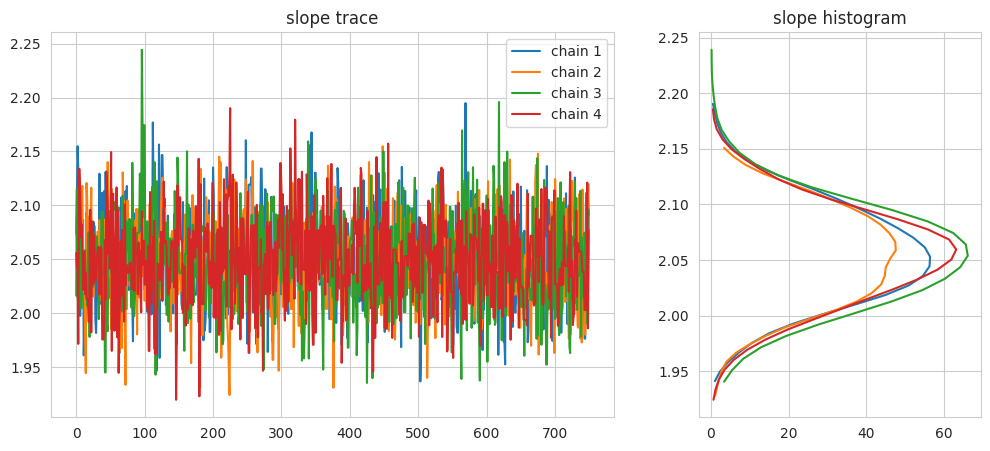

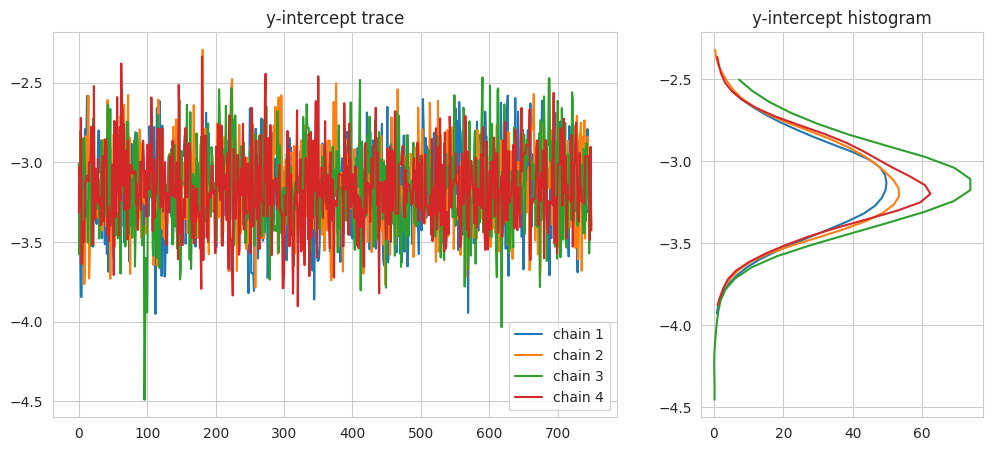

In [45]:
# plot trace and projected distribution

from scipy.stats import gaussian_kde

# map to physical params
unconstrained_HMC_m = samples[:,:,0]
unconstrained_HMC_b = samples[:,:,1]
physical_samples = fitter.bij.forward([unconstrained_HMC_m, unconstrained_HMC_b])
slope_samples = physical_samples['slope'].numpy()
y_intercept_samples = physical_samples['y_intercept'].numpy()

# slope trace
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios = [2,1])
axs[0].set_title('slope trace')
axs[0].plot(slope_samples[:,0:4], label=['chain 1','chain 2','chain 3','chain 4']);
axs[0].legend()

# slope projected distribution
for i in range(4):
  hist, bin_edges = np.histogram(slope_samples[:,i], bins=30)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
  X = slope_samples[:,i]
  #X_plot = np.linspace(bin_edges[0], bin_edges[-1], 1000)[:,np.newaxis]
  #kde = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(X)
  #log_dens = kde.score_samples(X_plot)

  win = signal.windows.hann(10)
  filtered = signal.convolve(hist, win, mode='same') / sum(win)
  axs[1].plot(filtered, bin_centers)
  #axs[1].plot(np.exp(log_dens), X_plot[:, 0])

axs[1].set_title('slope histogram')

# y intercept trace
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios = [2,1])
axs[0].set_title('y-intercept trace')
axs[0].plot(y_intercept_samples[:,0:4], label=['chain 1','chain 2','chain 3','chain 4']);
axs[0].legend()

# y intercept distribution
for i in range(4):
  hist, bin_edges = np.histogram(y_intercept_samples[:,i], bins=30)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
  X = y_intercept_samples[:,i].reshape(-1,1)
  win = signal.windows.hann(10)
  filtered = signal.convolve(hist, win, mode='same') / sum(win)
  axs[1].plot(filtered, bin_centers)
axs[1].set_title('y-intercept histogram')


In [46]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
ESS = tfp.mcmc.effective_sample_size(samples, cross_chain_dims=1).numpy()
print(Rhat, ESS)

[1.000694  1.0005851] [27380.117 26678.096]


(50, 750, 2)


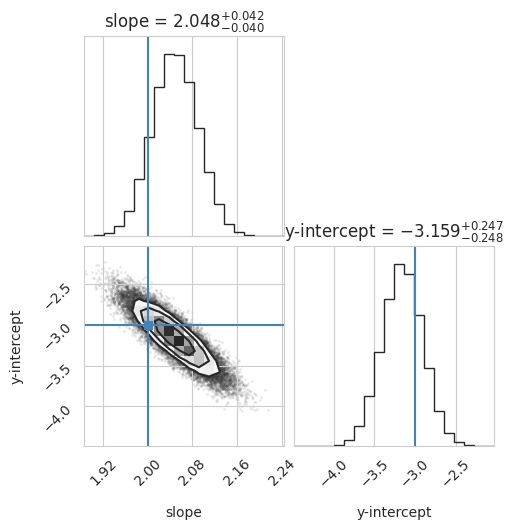

In [47]:
# HMC Corner plot
markers = get_samples(truth)

physical_samples = np.array([slope_samples, y_intercept_samples]).T.reshape(50,750,2)
print(np.shape(physical_samples))
corner(physical_samples, truths = markers, show_titles=True, title_fmt='.3f', labels = [r'slope', r'y-intercept']);

## Quadratic Fit

In [7]:
# define priors

quad_prior = tfd.JointDistributionNamed(
                  dict(
                      a = tfd.Uniform(-10., 10.),
                      b = tfd.Uniform(-10., 10.),
                      c = tfd.Uniform(-10., 10.)
                  )
)

2024-01-26 16:00:30.894571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 16:00:32.316053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 125 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2024-01-26 16:00:32.354486: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 125.06M (131137536 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [8]:
# quad bijectors

example = quad_prior.sample(20)
ays = example['a']
bs = example['b']
cs = example['c']

example = quad_prior.sample(seed=0)
size = int(tf.size(tf.nest.flatten(example)))
pack_bij = tfb.Chain(
    [
        tfb.pack_sequence_as(example),
    ]
)
unconstraining_bij = quad_prior.experimental_default_event_space_bijector()
bij = tfb.Chain([unconstraining_bij, pack_bij])


In [9]:
import random

# define truth parameters and noisy data

a = 2.0
b = -3.0
c = 1.0
err = 15.0

truth = [{'a': a, 'b': b, 'c': c}]

num_points = 100

x_observed = []
for i in range(num_points):
  x = random.uniform(-10,10)
  x_observed.append(x)

x_observed = tf.cast(tf.constant(x_observed),tf.float32)
a = tf.cast(tf.constant([a]),tf.float32)
b = tf.cast(tf.constant([b]),tf.float32)
c = tf.cast(tf.constant([c]),tf.float32)

@tf.function
def quad_model(x,params):
  a,b,c = params
  ax2 = tf.tensordot(a,x**2,axes=0)
  bx = tf.tensordot(b,x,axes=0)
  c_ = c[:,None]
  y = ax2 + bx + c_
  return y

def quad_noisy(x,params):
  a,b,c = params
  return quad_model(x,(a,b,c)) + np.random.normal(loc=0.0,scale = np.sqrt(err), size = len(x))

y_observed = quad_noisy(x_observed, (a,b,c))
y_observed = np.array(y_observed).flatten()
y_observed = tf.cast(tf.constant(y_observed),tf.float32)

# plot data points and truth line

plt.plot(x_observed, y_observed, '.', ms = 10)

plt.errorbar(x_observed, y_observed, yerr = err, marker = 's', fmt = 'None', ecolor = 'red', alpha = 0.3)

xs = np.array(x_observed)
ys = np.array(quad_model(x_observed,(a,b,c)).numpy()).flatten()

xs,ys = zip(*sorted(zip(xs, ys)))

plt.plot(xs, ys, color = 'orange')
plt.show()

2024-01-26 16:01:01.670736: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2024-01-26 16:01:01.670773: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2024-01-26 16:01:01.670833: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:438 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support
2024-01-26 16:01:01.674857: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2024-01-26 16:01:01.674875: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory

InternalError: Graph execution error:

Detected at node 'Tensordot_1/MatMul' defined at (most recent call last):
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_221051/3651457253.py", line 37, in <module>
      y_observed = quad_noisy(x_observed, (a,b,c))
    File "/tmp/ipykernel_221051/3651457253.py", line 35, in quad_noisy
      return quad_model(x,(a,b,c)) + np.random.normal(loc=0.0,scale = np.sqrt(err), size = len(x))
    File "/tmp/ipykernel_221051/3651457253.py", line 28, in quad_model
      bx = tf.tensordot(b,x,axes=0)
Node: 'Tensordot_1/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node Tensordot_1/MatMul}}]] [Op:__inference_quad_model_400]

In [55]:
from tqdm.auto import trange, tqdm

class QuadModellingSequence():
    def __init__(self, x_observed, y_observed):
        self.x_observed = x_observed
        self.y_observed = y_observed

        # line bijector
        example = quad_prior.sample(seed=0)
        self.pack_bij = tfb.Chain(
            [
                tfb.pack_sequence_as(example),
            ]
        )
        self.unconstraining_bij = quad_prior.experimental_default_event_space_bijector()
        self.bij = tfb.Chain([self.unconstraining_bij, self.pack_bij])

    #@tf.function
    def log_prob(self, x_observed, y_observed, a, b, c):

        # map parameters to constrained space
        constrained_params = self.bij.forward([a,b,c])
        a_bij = constrained_params['a']
        b_bij = constrained_params['b']
        c_bij = constrained_params['c']

        # reshaping to match reinterpreted_ batch_ndims
        y_model = tf.reshape(quad_model(x_observed, (a_bij,b_bij,c_bij)), (num_points,-1))
        y_model = tf.reshape(y_model,(len(a_bij),num_points))
        errs = tf.constant(err, shape=(len(a_bij),num_points))

        log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)
        log_prior = quad_prior.log_prob(dict(a=a_bij,b=b_bij,c=c_bij)) + self.unconstraining_bij.forward_log_det_jacobian(self.pack_bij.forward([a,b,c]))

        return log_like + log_prior, tf.reduce_mean((y_observed - quad_model(x_observed,(a_bij,b_bij,c_bij)))**2/errs, axis = 1)


    def MAP(self, optimizer, start=None, n_samples=500, num_steps=350, seed=0):
        tf.random.set_seed(seed)
        start = quad_prior.sample(n_samples)
        #ays = start['a']
        #bs = start['b']
        #cs = start['c']

        trial = tf.Variable(self.bij.inverse(start))

        ays_train = tf.Variable(trial[0])
        bs_train = tf.Variable(trial[1])
        cs_train = tf.Variable(trial[2])


        @tf.function
        def train_step():
            with tf.GradientTape() as tape:
                log_probability, square_err = self.log_prob(self.x_observed, self.y_observed, ays_train, bs_train, cs_train)
                agg_loss = tf.reduce_mean(-log_probability / len(x_observed))
            gradients = tape.gradient(agg_loss, [ays_train,bs_train, cs_train])
            optimizer.apply_gradients(zip(gradients, [ays_train,bs_train,cs_train]))

            return log_probability, square_err

        # get chi^2 and log probabilities for each step
        square_errs = []
        log_probs = []

        with trange(num_steps) as pbar:
            for _ in pbar:
                lp, square_err = train_step()
                square_errs.append(square_err)
                log_probs.append(lp)
                pbar.set_description(f"Chi Squared: {(np.nanmin(square_err)):.8f}")

        return ays_train, bs_train, cs_train, log_probs, square_errs

    @tf.function
    def log_prob_SVI(self, x_observed, y_observed, params):
        a = params[:,0]
        b = params[:,1]
        c = params[:,2]

        # map parameters to constrained space
        constrained_params = self.bij.forward([a,b,c])
        a_bij = constrained_params['a']
        b_bij = constrained_params['b']
        c_bij = constrained_params['c']

        y_model = tf.reshape(quad_model(x_observed, (a_bij,b_bij,c_bij)), (num_points,-1))
        y_model = tf.reshape(y_model,(len(a_bij),num_points))
        errs = tf.constant(err, shape=(len(a_bij),num_points))

        log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)
        log_prior = quad_prior.log_prob(dict(a=a_bij,b=b_bij,c=c_bij)) + self.unconstraining_bij.forward_log_det_jacobian(self.pack_bij.forward([a,b,c]))

        return tf.squeeze(log_like + log_prior)

    def SVI(self, optimizer, start, n_vi=250, init_scales=1e-3, num_steps=500, seed=2):
        tf.random.set_seed(seed)

        start = tf.squeeze(start)
        scale = (
          np.ones(len(start)).astype(np.float32) * init_scales
          if np.size(init_scales) == 1
          else init_scales
        )
        q_z = tfd.MultivariateNormalTriL(
          loc=tf.Variable(start),
          scale_tril=tfp.util.TransformedVariable(
              np.diag(scale),
              tfp.bijectors.FillScaleTriL(diag_bijector=tfb.Exp(), diag_shift=1e-6),
              name="stddev",
          ),
        )

        losses = tfp.vi.fit_surrogate_posterior(
          lambda z: self.log_prob_SVI(self.x_observed, self.y_observed, z),
          surrogate_posterior=q_z,
          sample_size=n_vi,
          optimizer=optimizer,
          num_steps=num_steps,

        )

        return q_z, losses

    def HMC(
          self,
          q_z,
          init_eps=0.3,
          init_l=3,
          n_hmc=50,
          num_burnin_steps=250,
          num_results=750,
          max_leapfrog_steps=30,
          seed=3,
          ):

      def tqdm_progress_bar_fn(num_steps):
          return iter(tqdm(range(num_steps), desc="", leave=True))

      tf.random.set_seed(seed)

      mc_start = q_z.sample(n_hmc)
      cov_estimate = q_z.covariance()

      momentum_distribution = (
          tfe.distributions.MultivariateNormalPrecisionFactorLinearOperator(
              precision_factor=tf.linalg.LinearOperatorLowerTriangular(
                  tf.linalg.cholesky(cov_estimate),
              ),
              precision=tf.linalg.LinearOperatorFullMatrix(cov_estimate),
          )
      )

      @tf.function
      def run_chain():
          num_adaptation_steps = int(num_burnin_steps * 0.8)
          start = tf.identity(mc_start)

          mc_kernel = tfe.mcmc.PreconditionedHamiltonianMonteCarlo(
              target_log_prob_fn=lambda z: self.log_prob_SVI(self.x_observed, self.y_observed, z),
              momentum_distribution=momentum_distribution,
              step_size=init_eps,
              num_leapfrog_steps=init_l,
          )

          mc_kernel = tfe.mcmc.GradientBasedTrajectoryLengthAdaptation(
              mc_kernel,
              num_adaptation_steps=num_adaptation_steps,
              max_leapfrog_steps=max_leapfrog_steps,
          )
          mc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
              inner_kernel=mc_kernel, num_adaptation_steps=num_adaptation_steps
          )

          pbar = tfe.mcmc.ProgressBarReducer(
              num_results + num_burnin_steps - 1, progress_bar_fn=tqdm_progress_bar_fn
          )
          mc_kernel = tfe.mcmc.WithReductions(mc_kernel, pbar)

          return tfp.mcmc.sample_chain(
              num_results=num_results,
              num_burnin_steps=num_burnin_steps,
              current_state=start,
              kernel=mc_kernel,
              seed=seed,
          )

      return run_chain()


In [56]:
fitter = QuadModellingSequence(x_observed, y_observed)

In [57]:
# fitting MAP

schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-1, 500, 1e-3)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=500, num_steps=500, seed=0)

  0%|          | 0/500 [00:00<?, ?it/s]

In [58]:
# get best MAP results
ays_train, bs_train, cs_train, log_probs, square_errs = MAP
lps = fitter.log_prob(x_observed, y_observed, ays_train, bs_train, cs_train)[0]
best_idx = tf.argmax(lps).numpy()
MAP_a = ays_train[best_idx].numpy()
MAP_b = bs_train[best_idx].numpy()
MAP_c = cs_train[best_idx].numpy()

best = tf.constant([MAP_a, MAP_b, MAP_c])

# map to physical parameters

MAP_bij = fitter.bij.forward([MAP_a, MAP_b, MAP_c])
MAP_a_bij = MAP_bij['a'].numpy()
MAP_b_bij = MAP_bij['b'].numpy()
MAP_c_bij = MAP_bij['c'].numpy()
best_bij = tf.constant([MAP_a_bij, MAP_b_bij, MAP_c_bij])

print(best)
print(best_bij)

tf.Tensor([ 0.4097863  -0.59497935  0.03117831], shape=(3,), dtype=float32)
tf.Tensor([ 2.0207334  -2.8901367   0.15587902], shape=(3,), dtype=float32)


Text(0.5, 1.0, 'best -log prob vs steps')

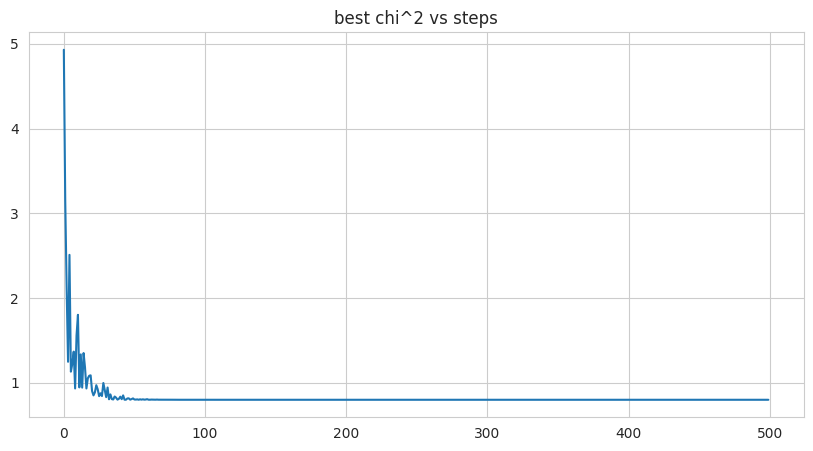

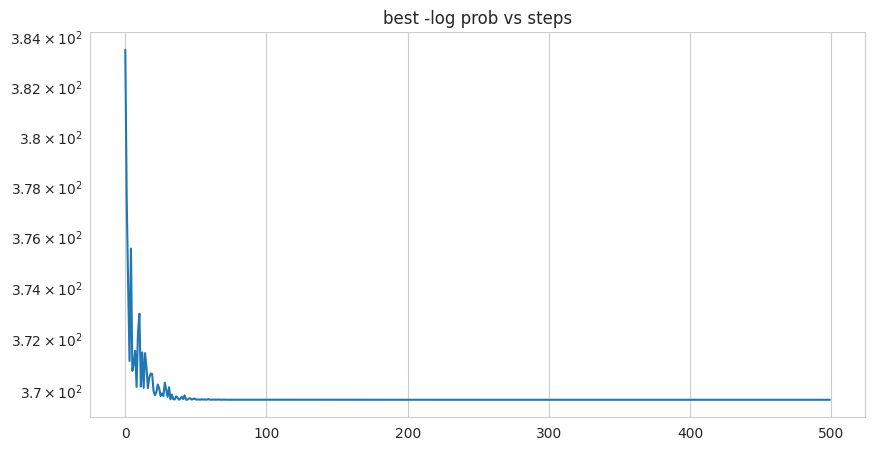

In [60]:
# plot best walker at each iteration

chi2s = np.array(square_errs)
best_chi2s = []
for i in range(len(chi2s[:,0])):
  best_chi2_idx = np.argmin(chi2s[i,:])
  best_chi2 = chi2s[i,best_chi2_idx]
  best_chi2s.append(best_chi2)

best_chi2s = np.array(best_chi2s)


plt.figure(figsize=(10, 5))
plt.plot(best_chi2s)
plt.title('best chi^2 vs steps')


log_probs = np.array(log_probs)
best_log_probs = []
for i in range(len(log_probs[:,0])):
  best_log_prob_idx = np.argmax(log_probs[i,:])
  best_log_prob = log_probs[i,best_log_prob_idx]
  best_log_probs.append(best_log_prob)

best_log_probs = np.array(best_log_probs)

plt.figure(figsize=(10, 5))
plt.plot(-best_log_probs)
plt.yscale('log')
plt.title('best -log prob vs steps')



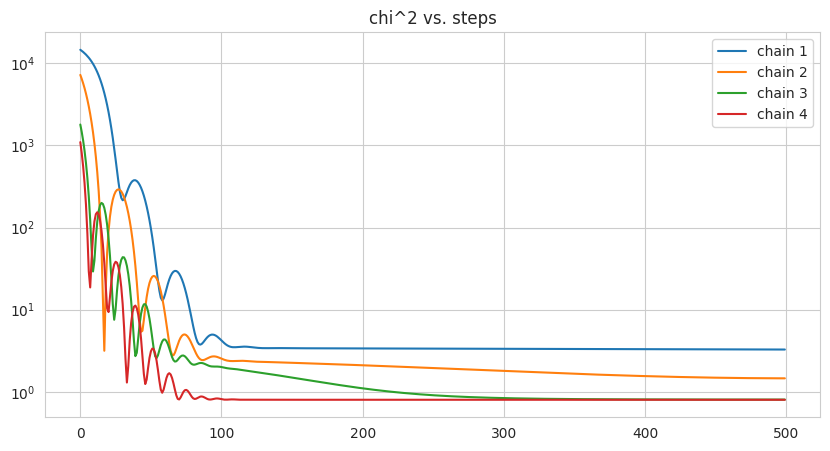

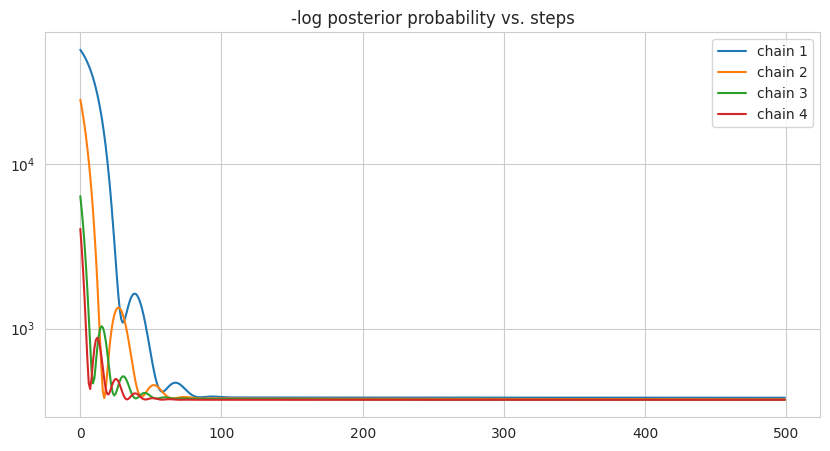

In [61]:
# chi^2 plot
chi2s = np.array(square_errs)
chain = chi2s[:,0:4]

plt.figure(figsize=(10, 5))
plt.plot(chain, label=['chain 1','chain 2','chain 3','chain 4']);
plt.yscale('log')
plt.title('chi^2 vs. steps')
plt.legend()

# posterior probability plot
log_probs = np.array(log_probs)
chain = log_probs[:,0:4]

plt.figure(figsize=(10, 5))
plt.plot(-chain, label=['chain 1','chain 2','chain 3','chain 4']);
plt.title('-log posterior probability vs. steps')
plt.yscale('log')
plt.legend()

In [62]:
# fit SVI
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=300, num_steps=1400)

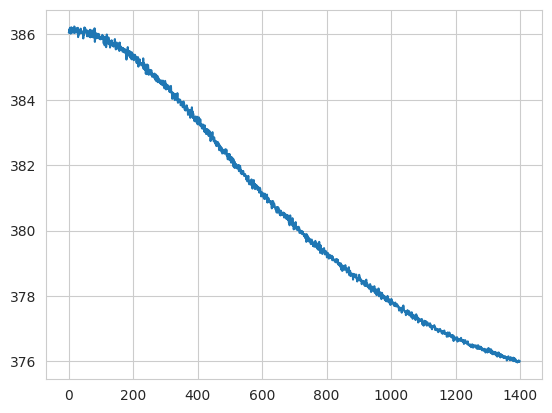

In [63]:
plt.plot(losses)

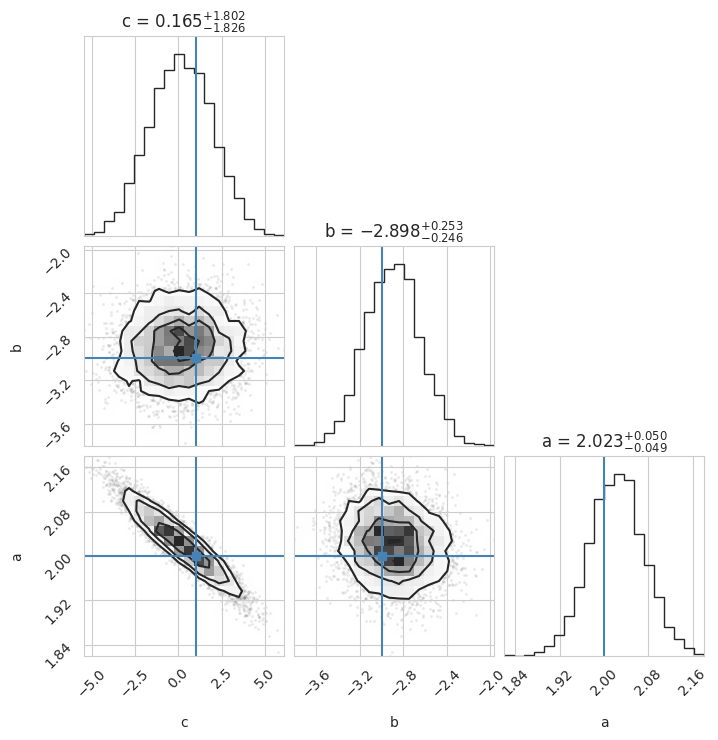

In [64]:
# make corner plot for SVI step
get_samples = lambda x:tf.convert_to_tensor([
    x[0]['a'],
    x[0]['b'],
    x[0]['c']
])

unconstrained_samples = q_z.sample(5000)

# map to physical space
unconstrained_as = unconstrained_samples[:,0]
unconstrained_bs = unconstrained_samples[:,1]
unconstrained_cs = unconstrained_samples[:,2]

physical_samples = fitter.bij.forward([unconstrained_as, unconstrained_bs, unconstrained_cs])

markers = get_samples(truth)
corner(physical_samples, truths = truth[0], show_titles=True, title_fmt='.3f', labels = [r'c', r'b', r'a']);


In [65]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

Text(0.5, 1.0, 'c histogram')

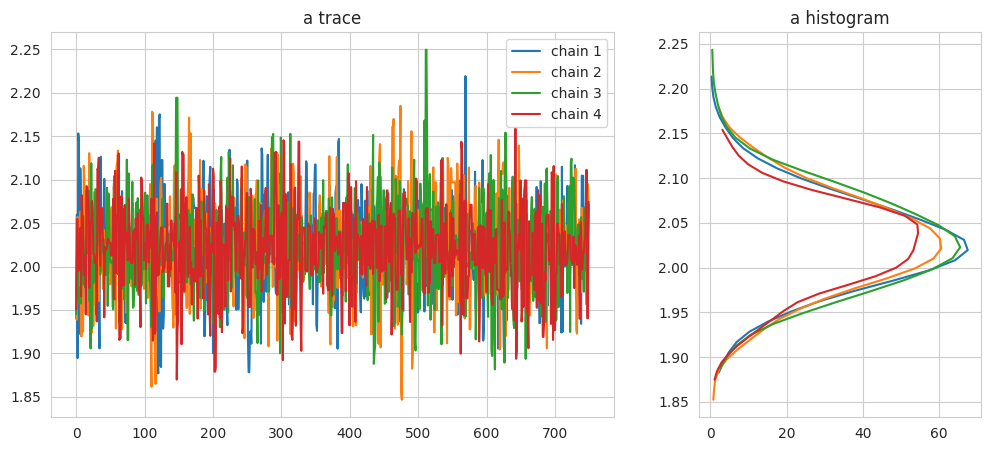

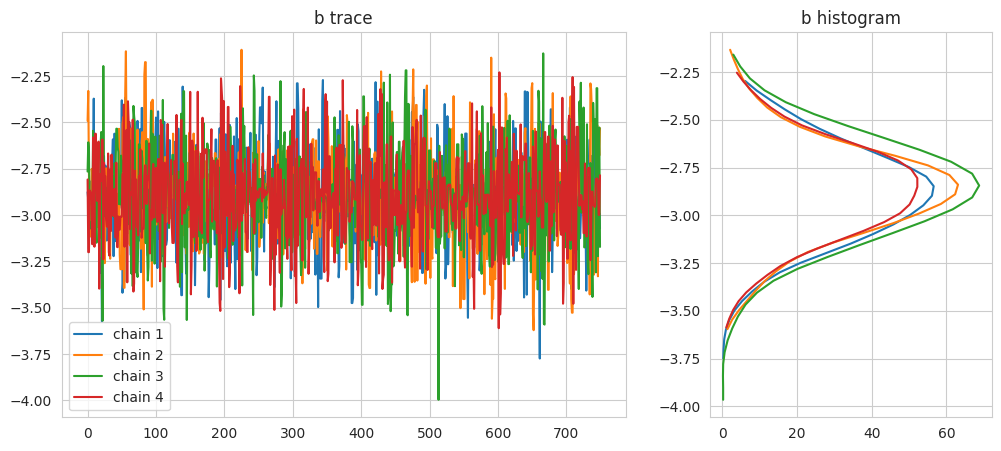

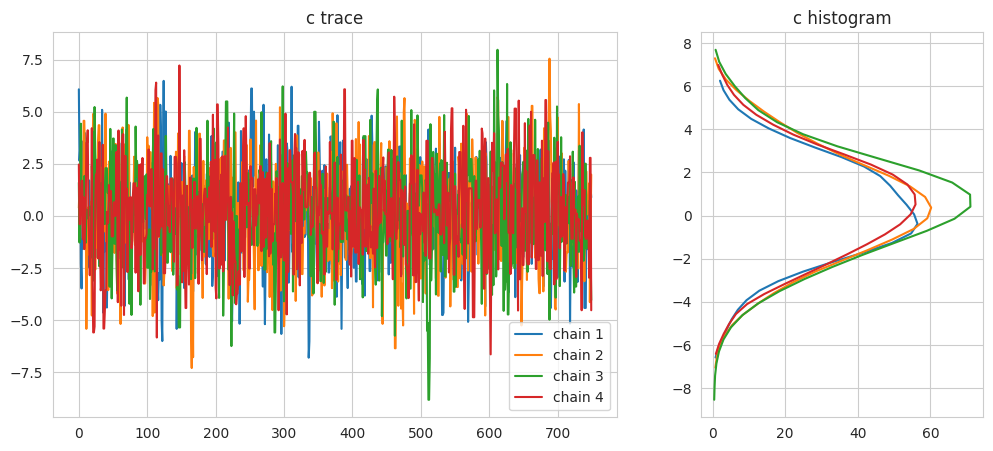

In [66]:
# plot trace and projected distribution

from scipy.interpolate import make_interp_spline

# map to physical params
unconstrained_HMC_a = samples[:,:,0]
unconstrained_HMC_b = samples[:,:,1]
unconstrained_HMC_c = samples[:,:,2]
physical_samples = fitter.bij.forward([unconstrained_HMC_a, unconstrained_HMC_b, unconstrained_HMC_c])
a_samples = physical_samples['a'].numpy()
b_samples = physical_samples['b'].numpy()
c_samples = physical_samples['c'].numpy()

# a trace
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios = [2,1])
axs[0].set_title('a trace')
axs[0].plot(a_samples[:,0:4], label=['chain 1','chain 2','chain 3','chain 4']);
axs[0].legend()

# a projected distribution
for i in range(4):
  hist, bin_edges = np.histogram(a_samples[:,i], bins=30)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
  X = a_samples[:,i].reshape(-1,1)
  win = signal.windows.hann(10)
  filtered = signal.convolve(hist, win, mode='same') / sum(win)
  axs[1].plot(filtered, bin_centers)
axs[1].set_title('a histogram')

# b trace
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios = [2,1])
axs[0].set_title('b trace')
axs[0].plot(b_samples[:,0:4], label=['chain 1','chain 2','chain 3','chain 4']);
axs[0].legend()

# b distribution
for i in range(4):
  hist, bin_edges = np.histogram(b_samples[:,i], bins=30)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
  X = b_samples[:,i].reshape(-1,1)
  win = signal.windows.hann(10)
  filtered = signal.convolve(hist, win, mode='same') / sum(win)
  axs[1].plot(filtered, bin_centers)
axs[1].set_title('b histogram')

# c trace
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios = [2,1])
axs[0].set_title('c trace')
axs[0].plot(c_samples[:,0:4], label=['chain 1','chain 2','chain 3','chain 4']);
axs[0].legend()

# c distribution
for i in range(4):
  hist, bin_edges = np.histogram(c_samples[:,i], bins=30)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
  X = c_samples[:,i].reshape(-1,1)
  win = signal.windows.hann(10)
  filtered = signal.convolve(hist, win, mode='same') / sum(win)
  axs[1].plot(filtered, bin_centers)
axs[1].set_title('c histogram')








In [67]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
ESS = tfp.mcmc.effective_sample_size(samples, cross_chain_dims=1).numpy()
print(Rhat, ESS)

[0.99952716 0.99979    1.0002276 ] [31128.223 33347.906 26320.424]


(50, 750, 3)


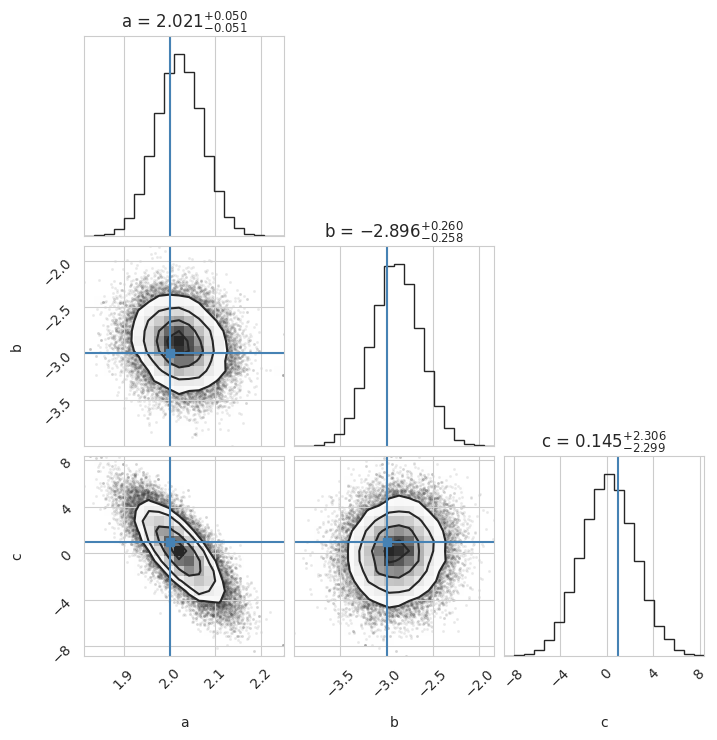

In [68]:
# HMC Corner plot
markers = get_samples(truth)

physical_samples = np.array([a_samples, b_samples, c_samples]).T.reshape(50,750,3)
print(np.shape(physical_samples))
corner(physical_samples, truths = markers, show_titles=True, title_fmt='.3f', labels = [r'a', r'b', r'c']);

## Singularity Fit

In [69]:
# define priors

sing_prior = tfd.JointDistributionNamed(
                  dict(
                      #A = tfd.TruncatedNormal(loc=5.0, scale=6.0, low=-10., high=15.),
                      A = tfd.Uniform(-10.,10.),
                      x_0 = tfd.Uniform(-10., 10.)
                  )
)

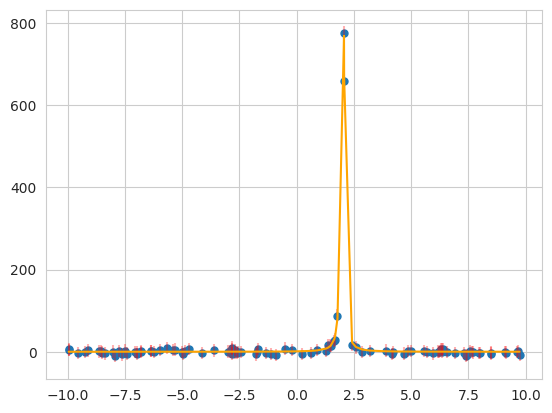

In [70]:
import random

# define truth parameters and noisy data

A = 4.0
x_0 = 2.0
err = 15.0

# function parameters
delta = 0.001

truth = [{'A': A, 'x_0': x_0}]

num_points = 100

x_observed = []
for i in range(num_points):
  x = random.uniform(-10,10)
  x_observed.append(x)

x_observed = tf.cast(tf.constant(x_observed),tf.float32)
A = tf.cast(tf.constant([A]),tf.float32)
x_0 = tf.cast(tf.constant([x_0]),tf.float32)
delta = tf.cast(tf.constant([delta]),tf.float32)

@tf.function
def sing_model(x,params):
  A, x_0 = params

  xs_term = tf.math.square((x - x_0[:,None]))

  denom = xs_term + delta[:,None]

  y = A[:,None]/denom

  return y

def sing_noisy(x,params):
  A,m_0 = params
  return sing_model(x,(A,x_0)) + np.random.normal(loc=0.0,scale = np.sqrt(err), size = len(x_observed))

y_observed = sing_noisy(x_observed, (A,x_0))
y_observed = np.array(y_observed).flatten()
y_observed = tf.cast(tf.constant(y_observed),tf.float32)

# plot data points and truth line

plt.plot(x_observed, y_observed, '.', ms = 10)

plt.errorbar(x_observed, y_observed, yerr = err, marker = 's', fmt = 'None', ecolor = 'red', alpha = 0.3)

xs = np.array(x_observed)
ys = np.array(sing_model(x_observed,(A,x_0)).numpy()).flatten()

xs,ys = zip(*sorted(zip(xs, ys)))

plt.plot(xs, ys, color = 'orange')
plt.show()

In [71]:
from tqdm.auto import trange, tqdm

class SingModellingSequence():
    def __init__(self, x_observed, y_observed):
        self.x_observed = x_observed
        self.y_observed = y_observed

        # line bijector
        example = sing_prior.sample(seed=0)
        self.pack_bij = tfb.Chain(
            [
                tfb.pack_sequence_as(example),
            ]
        )
        self.unconstraining_bij = sing_prior.experimental_default_event_space_bijector()
        self.bij = tfb.Chain([self.unconstraining_bij, self.pack_bij])

    #@tf.function
    def log_prob(self, x_observed, y_observed, A, x_0):

        # map parameters to constrained space
        constrained_params = self.bij.forward([A, x_0])
        A_bij = constrained_params['A']
        x_0_bij = constrained_params['x_0']

        # reshaping to match reinterpreted_ batch_ndims
        y_model = tf.reshape(sing_model(x_observed, (A_bij, x_0_bij)), (num_points,-1))
        y_model = tf.reshape(y_model,(len(A_bij),num_points))
        errs = tf.constant(err, shape=(len(A_bij),num_points))

        log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)
        log_prior = sing_prior.log_prob(dict(A=A_bij,x_0=x_0_bij)) + self.unconstraining_bij.forward_log_det_jacobian(self.pack_bij.forward([A,x_0]))

        return log_like + log_prior, tf.reduce_mean((y_observed - sing_model(x_observed,(A_bij,x_0_bij)))**2/errs, axis = 1)


    def MAP(self, optimizer, start=None, n_samples=500, num_steps=350, seed=0):
        tf.random.set_seed(seed)
        start = sing_prior.sample(n_samples)

        trial = tf.Variable(self.bij.inverse(start))

        As_train = tf.Variable(trial[0])
        x_0s_train = tf.Variable(trial[1])

        @tf.function
        def train_step():
            with tf.GradientTape() as tape:
                log_probability, square_err = self.log_prob(self.x_observed, self.y_observed, As_train, x_0s_train)
                agg_loss = tf.reduce_mean(-log_probability / len(x_observed))
            gradients = tape.gradient(agg_loss, [As_train,x_0s_train])
            optimizer.apply_gradients(zip(gradients, [As_train,x_0s_train]))

            return log_probability, square_err

        # get chi^2 and log probabilities for each step
        square_errs = []
        log_probs = []

        with trange(num_steps) as pbar:
            for _ in pbar:
                lp, square_err = train_step()
                square_errs.append(square_err)
                log_probs.append(lp)
                pbar.set_description(f"Chi Squared: {(np.nanmin(square_err)):.8f}")

        return As_train, x_0s_train, log_probs, square_errs

    @tf.function
    def log_prob_SVI(self, x_observed, y_observed, params):
        A = params[:,0]
        x_0 = params[:,1]

        # map parameters to constrained space
        constrained_params = self.bij.forward([A,x_0])
        A_bij = constrained_params['A']
        x_0_bij = constrained_params['x_0']

        y_model = tf.reshape(sing_model(x_observed, (A_bij, x_0_bij)), (num_points,-1))
        y_model = tf.reshape(y_model,(len(A_bij),num_points))
        errs = tf.constant(err, shape=(len(A_bij),num_points))

        log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)
        log_prior = sing_prior.log_prob(dict(A=A_bij,x_0=x_0_bij)) + self.unconstraining_bij.forward_log_det_jacobian(self.pack_bij.forward([A,x_0]))

        return tf.squeeze(log_like + log_prior)

    def SVI(self, optimizer, start, n_vi=250, init_scales=1e-3, num_steps=500, seed=2):
        tf.random.set_seed(seed)

        start = tf.squeeze(start)
        scale = (
          np.ones(len(start)).astype(np.float32) * init_scales
          if np.size(init_scales) == 1
          else init_scales
        )
        q_z = tfd.MultivariateNormalTriL(
          loc=tf.Variable(start),
          scale_tril=tfp.util.TransformedVariable(
              np.diag(scale),
              tfp.bijectors.FillScaleTriL(diag_bijector=tfb.Exp(), diag_shift=1e-6),
              name="stddev",
          ),
        )

        losses = tfp.vi.fit_surrogate_posterior(
          lambda z: self.log_prob_SVI(self.x_observed, self.y_observed, z),
          surrogate_posterior=q_z,
          sample_size=n_vi,
          optimizer=optimizer,
          num_steps=num_steps,

        )

        return q_z, losses

    def HMC(
          self,
          q_z,
          init_eps=0.3,
          init_l=3,
          n_hmc=50,
          num_burnin_steps=250,
          num_results=750,
          max_leapfrog_steps=30,
          seed=3,
          ):

      def tqdm_progress_bar_fn(num_steps):
          return iter(tqdm(range(num_steps), desc="", leave=True))

      tf.random.set_seed(seed)

      mc_start = q_z.sample(n_hmc)
      cov_estimate = q_z.covariance()

      momentum_distribution = (
          tfe.distributions.MultivariateNormalPrecisionFactorLinearOperator(
              precision_factor=tf.linalg.LinearOperatorLowerTriangular(
                  tf.linalg.cholesky(cov_estimate),
              ),
              precision=tf.linalg.LinearOperatorFullMatrix(cov_estimate),
          )
      )

      @tf.function
      def run_chain():
          num_adaptation_steps = int(num_burnin_steps * 0.8)
          start = tf.identity(mc_start)

          mc_kernel = tfe.mcmc.PreconditionedHamiltonianMonteCarlo(
              target_log_prob_fn=lambda z: self.log_prob_SVI(self.x_observed, self.y_observed, z),
              momentum_distribution=momentum_distribution,
              step_size=init_eps,
              num_leapfrog_steps=init_l,
          )

          mc_kernel = tfe.mcmc.GradientBasedTrajectoryLengthAdaptation(
              mc_kernel,
              num_adaptation_steps=num_adaptation_steps,
              max_leapfrog_steps=max_leapfrog_steps,
          )
          mc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
              inner_kernel=mc_kernel, num_adaptation_steps=num_adaptation_steps
          )

          pbar = tfe.mcmc.ProgressBarReducer(
              num_results + num_burnin_steps - 1, progress_bar_fn=tqdm_progress_bar_fn
          )
          mc_kernel = tfe.mcmc.WithReductions(mc_kernel, pbar)

          return tfp.mcmc.sample_chain(
              num_results=num_results,
              num_burnin_steps=num_burnin_steps,
              current_state=start,
              kernel=mc_kernel,
              seed=seed,
          )

      return run_chain()


In [72]:
fitter = SingModellingSequence(x_observed, y_observed)

In [73]:
# fitting MAP

schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-1, 500, 1e-3)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=500, num_steps=500, seed=0)

  0%|          | 0/500 [00:00<?, ?it/s]

In [74]:
# get best MAP results
As_train, x_0_train, log_probs, square_errs = MAP
lps = fitter.log_prob(x_observed, y_observed, As_train, x_0_train)[0]
best_idx = tf.argmax(lps).numpy()
MAP_A = As_train[best_idx].numpy()
MAP_x_0 = x_0_train[best_idx].numpy()

best = tf.constant([MAP_A, MAP_x_0])

# map to physical parameters

MAP_bij = fitter.bij.forward([MAP_A, MAP_x_0])
MAP_A_bij = MAP_bij['A'].numpy()
MAP_x_0_bij = MAP_bij['x_0'].numpy()
best_bij = tf.constant([MAP_A_bij, MAP_x_0_bij])

print(best)
print(best_bij)

tf.Tensor([0.79925615 0.40592015], shape=(2,), dtype=float32)
tf.Tensor([3.7963066 2.0021844], shape=(2,), dtype=float32)


Text(0.5, 1.0, 'best -log prob vs steps')

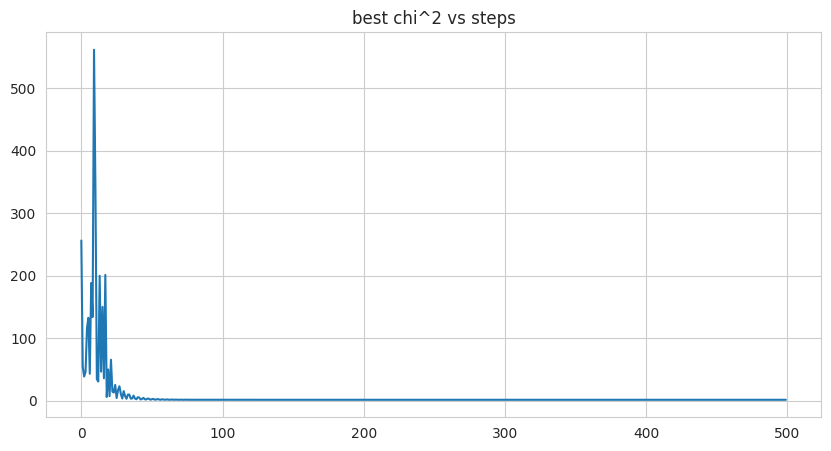

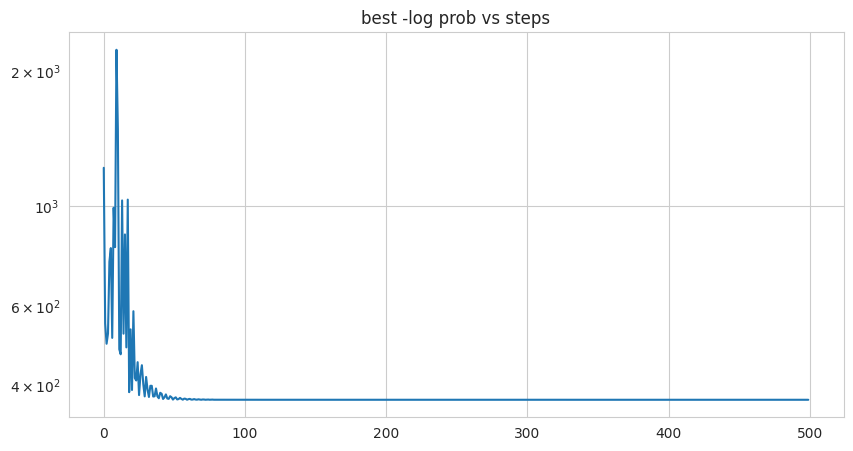

In [76]:
# plot best walker at each iteration

chi2s = np.array(square_errs)
best_chi2s = []
for i in range(len(chi2s[:,0])):
  best_chi2_idx = np.argmin(chi2s[i,:])
  best_chi2 = chi2s[i,best_chi2_idx]
  best_chi2s.append(best_chi2)

best_chi2s = np.array(best_chi2s)


plt.figure(figsize=(10, 5))
plt.plot(best_chi2s)
plt.title('best chi^2 vs steps')


log_probs = np.array(log_probs)
best_log_probs = []
for i in range(len(log_probs[:,0])):
  best_log_prob_idx = np.argmax(log_probs[i,:])
  best_log_prob = log_probs[i,best_log_prob_idx]
  best_log_probs.append(best_log_prob)

best_log_probs = np.array(best_log_probs)

plt.figure(figsize=(10, 5))
plt.plot(-best_log_probs)
plt.yscale('log')
plt.title('best -log prob vs steps')



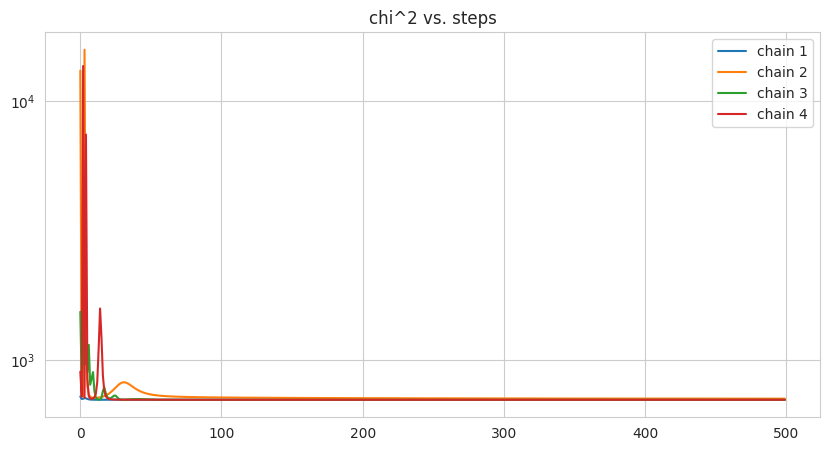

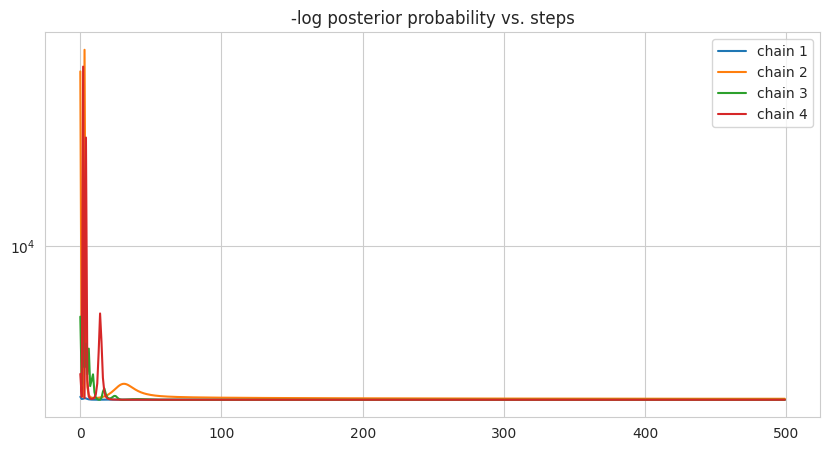

In [77]:
# chi^2 plot
chi2s = np.array(square_errs)
chain = chi2s[:,0:4]

plt.figure(figsize=(10, 5))
plt.plot(chain, label=['chain 1','chain 2','chain 3','chain 4']);
plt.yscale('log')
plt.title('chi^2 vs. steps')
plt.legend()

# posterior probability plot
log_probs = np.array(log_probs)
chain = log_probs[:,0:4]

plt.figure(figsize=(10, 5))
plt.plot(-chain, label=['chain 1','chain 2','chain 3','chain 4']);
plt.yscale('log')
plt.title('-log posterior probability vs. steps')
plt.legend()


In [78]:
# fit SVI
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=300, num_steps=1400)

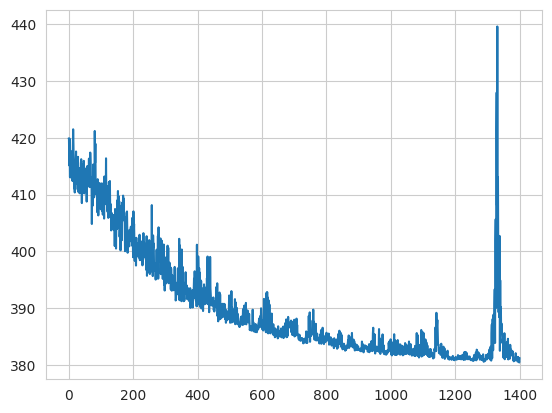

In [79]:
plt.plot(losses)

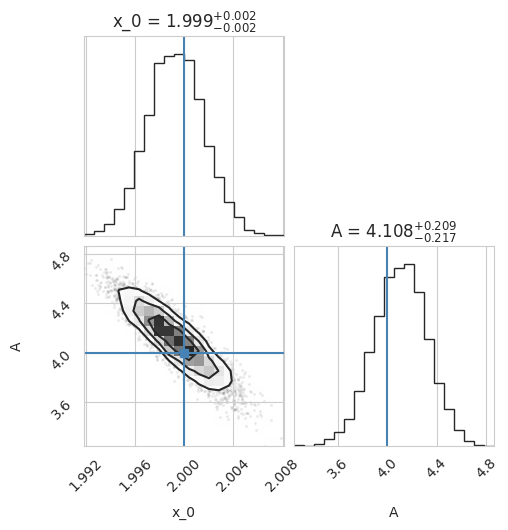

In [80]:
# make corner plot for SVI step
get_samples = lambda x:tf.convert_to_tensor([
    x[0]['A'],
    x[0]['x_0']
])

unconstrained_samples = q_z.sample(5000)

# map to physical space
unconstrained_As = unconstrained_samples[:,0]
unconstrained_x_0s = unconstrained_samples[:,1]

physical_samples = fitter.bij.forward([unconstrained_As, unconstrained_x_0s])

markers = get_samples(truth)
corner(physical_samples, truths = truth[0], show_titles=True, title_fmt='.3f', labels = [r'x_0', r'A']);

In [81]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

Text(0.5, 1.0, 'x_0 histogram')

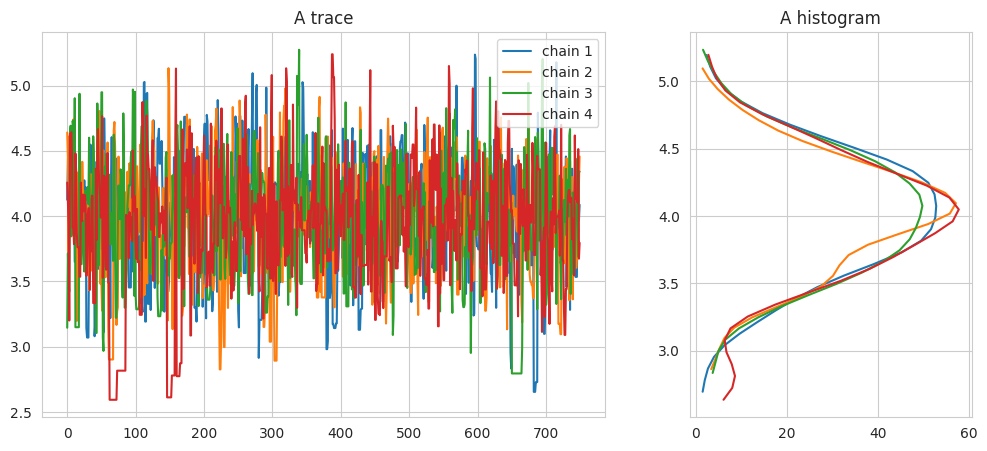

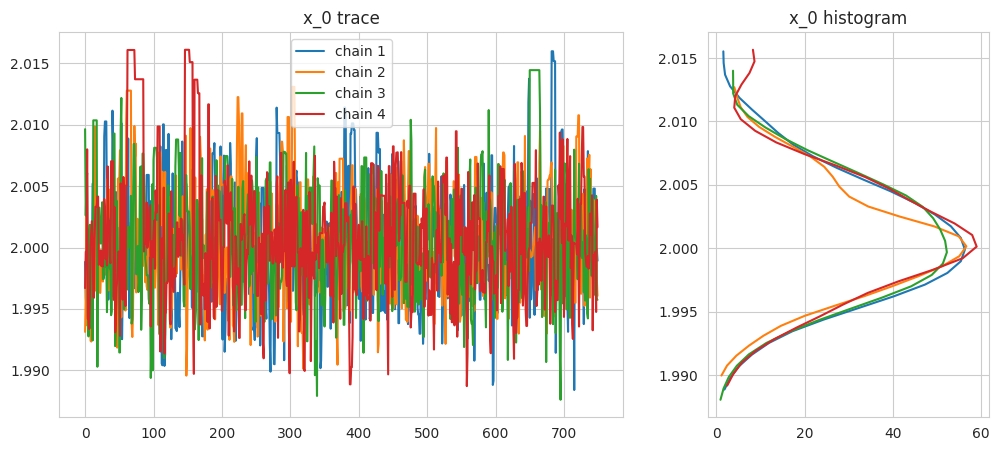

In [82]:
# plot trace and projected distribution

from sklearn.neighbors import KernelDensity
from scipy.interpolate import make_interp_spline

# map to physical params
unconstrained_HMC_A = samples[:,:,0]
unconstrained_HMC_x_0 = samples[:,:,1]
physical_samples = fitter.bij.forward([unconstrained_HMC_A, unconstrained_HMC_x_0])
A_samples = physical_samples['A'].numpy()
x_0_samples = physical_samples['x_0'].numpy()

# A trace
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios = [2,1])
axs[0].set_title('A trace')
axs[0].plot(A_samples[:,0:4], label=['chain 1','chain 2','chain 3','chain 4']);
axs[0].legend()

# A projected distribution
for i in range(4):
  hist, bin_edges = np.histogram(A_samples[:,i], bins=30)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
  X = A_samples[:,i].reshape(-1,1)
  win = signal.windows.hann(10)
  filtered = signal.convolve(hist, win, mode='same') / sum(win)
  axs[1].plot(filtered, bin_centers)
axs[1].set_title('A histogram')

# x_0 trace
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios = [2,1])
axs[0].set_title('x_0 trace')
axs[0].plot(x_0_samples[:,0:4], label=['chain 1','chain 2','chain 3','chain 4']);
axs[0].legend()

# x_0 distribution
for i in range(4):
  hist, bin_edges = np.histogram(x_0_samples[:,i], bins=30)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
  X = x_0_samples[:,i].reshape(-1,1)
  win = signal.windows.hann(10)
  filtered = signal.convolve(hist, win, mode='same') / sum(win)
  axs[1].plot(filtered, bin_centers)
axs[1].set_title('x_0 histogram')


In [83]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
ESS = tfp.mcmc.effective_sample_size(samples, cross_chain_dims=1).numpy()
print(Rhat, ESS)

[1.0028259 1.0035414] [9778.891 8554.904]


(50, 750, 2)


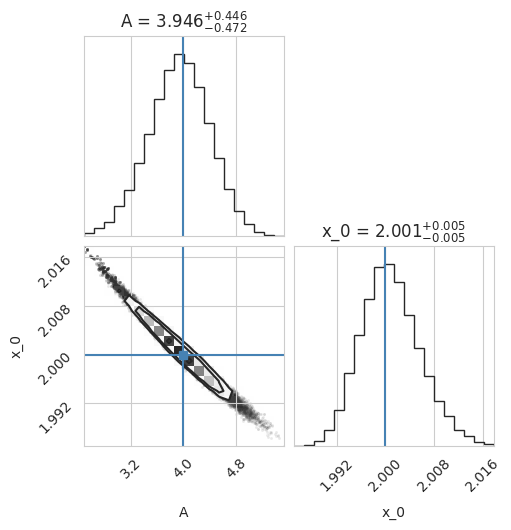

In [84]:
# HMC Corner plot
markers = get_samples(truth)


physical_samples = np.array([A_samples, x_0_samples]).T.reshape(50,750,2)
print(np.shape(physical_samples))
corner(physical_samples, truths = markers, show_titles=True, title_fmt='.3f', labels = [r'A', r'x_0']);